#LSTM

* LSTM 만 이용해서 이상탐지를 하는 것은 더욱 어렵습니다.
* 이번 예제는 LSTM을 사용해보고,
* 단변량 시계열에서 이상탐지를 하는 방법 하나를 소개합니다.


# [1] LSTM으로 서울시 기온 예측

단변량 온도 데이터를 이용하여, 이후 온도를 예측하는 모델을 만들어 봅시다.

## 1.환경 준비

### (1) Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, TimeDistributed
from keras.backend import clear_session
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

### (2)  Data Loading

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
...,...,...,...
260,2014,49,8.100000
261,2014,50,-4.357143
262,2014,51,-2.142857
263,2014,52,-5.542857


온도의 흐름(trend)을 살펴봅시다.

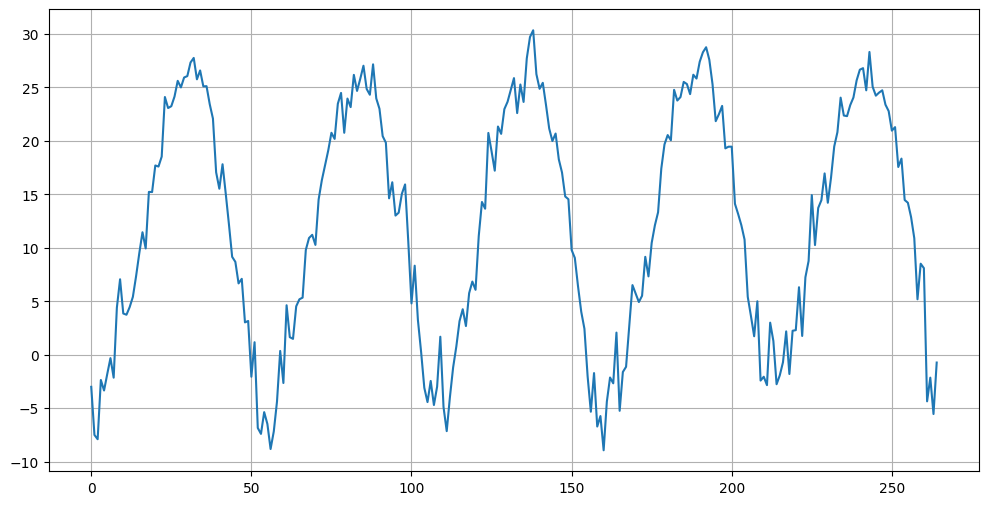

In [3]:
plt.figure(figsize = (12,6))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

### (3) 필요한 함수 만들기

* 시계열 데이터 분석을 위한 전처리(for LSTM, CNN)

In [4]:
def temporalize(X, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(X) - timestep + 1):
        t = []
        for j in range(timestep):
            t.append(X[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X), axis=3), np.array(output_y)

* 학습곡선그래프

In [5]:
def plot_learning_curve(history) :
    plt.figure(figsize = (10,6))
    plt.plot(history['loss'], label='Train', marker = '.')
    plt.plot(history['val_loss'], label='Validation', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

## 2.데이터 준비

### (1) LSTM을 위한 데이터 만들기

In [6]:
data.head()

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857


In [7]:
# 2차원 X와 y 준비하기
input_x = data[['AvgTemp']].values
input_y = data.AvgTemp.shift(-1).values

In [8]:
input_x[:5]

array([[-3.        ],
       [-7.5       ],
       [-7.9       ],
       [-2.35714286],
       [-3.34285714]])

In [9]:
input_y[:5]

array([-7.5       , -7.9       , -2.35714286, -3.34285714, -1.8       ])

In [10]:
# 여기서는 아래와 같이 간단하게 스케일링 진행합니다.
x_max = input_x.max()
x_min = input_x.min()
input_x = (input_x - x_min) / (x_max - x_min)
input_y = (input_y - x_min) / (x_max - x_min)

In [11]:
# 분석을 위한 시간간격(timestep)을 지정합니다.
timestep = 10

# 2차원 x --> 3차원 x
x, y = temporalize(input_x, input_y, timestep)

In [12]:
input_x.shape

(265, 1)

In [13]:
x.shape, y.shape

((256, 10, 1), (256,))

### (2) 데이터 확인해보기

* 첫번째 데이터 x 와 y

In [17]:
pd.DataFrame(x[0])

,0
0,0.151067
1,0.036494
2,0.026309
3,0.167435
4,0.142338
5,0.181620
6,0.219447
7,0.172890
8,0.339476
9,0.407129


In [15]:
y[0]

0.3256547041850374

* 두번째 데이터와 비교하기

In [18]:
pd.DataFrame(x[1])

,0
0,0.036494
1,0.026309
2,0.167435
3,0.142338
4,0.181620
5,0.219447
6,0.172890
7,0.339476
8,0.407129
9,0.325655


### (3) 데이터분할

* 52주(1년) 데이터를 검증용으로 분리합시다.

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=52, 
                                                  shuffle = False)

## 3.모델링 : LSTM

### (1) 모델 구조

In [21]:
clear_session()

model = Sequential([ LSTM(30, input_shape = (10,1)),
                    Dense(1) ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


### (2) 컴파일 및 학습

In [ ]:
model.compile(loss="mse", optimizer= Adam(lr=0.005))
history = model.fit(x_train, y_train, epochs=50, validation_split=.2).history

* 학습 곡선 확인

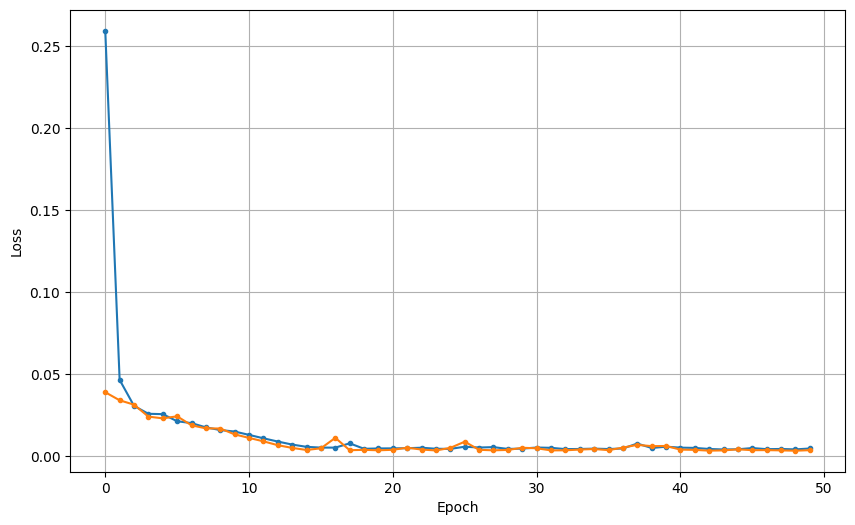

In [23]:
plot_learning_curve(history)

### (3) 검증

In [24]:
x_val.shape

(52, 10, 1)

In [25]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 7ms/step


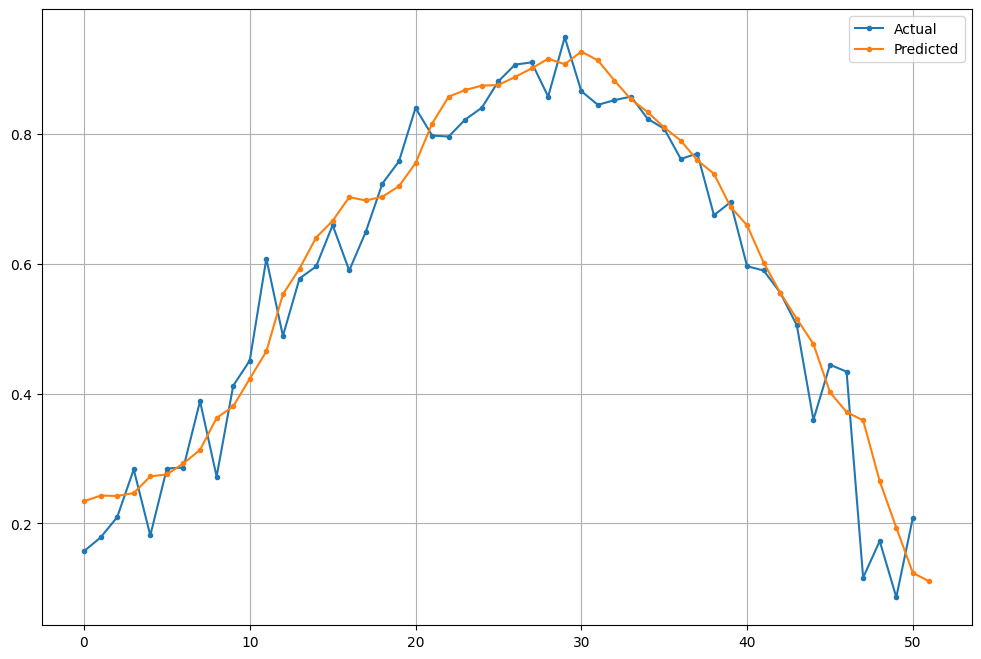

In [26]:
plt.figure(figsize = (12,8))
plt.plot(y_val, label = 'Actual', marker = '.')
plt.plot(pred, label = 'Predicted', marker = '.')
plt.legend()
plt.grid()
plt.show()

# [2] LSTM을 이용한 단변량 이상 탐지 예제

> LSTM을 다음과 같이 이용하려고 합니다.
* Input(timestep) 만큼, Output을 예측값으로 구하고,
* Input과 Output과의 차이(error)를 구해서
* 차이가 큰 값들을 이상치로 간주하려고 합니다.


## 1.환경준비

### (1) 라이브러리 로딩

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, TimeDistributed
from keras.backend import clear_session
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

### (2) 데이터셋 불러오기
* 데이터는 서버의 CPU 사용율 정보입니다.
* 데이터는 5분 간격입니다.
    * 하루 데이터는 총 288행 입니다.
* 총 14일 동안의 데이터입니다. ('2014-02-14 14:30:00' ~ '2014-02-28 14:30:00')

In [28]:
# CPU 사용량
df = pd.read_csv("https://raw.githubusercontent.com/DA4BAM/dataset/master/rds_cpu_utilization.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

,timestamp,value
0,2014-02-14 14:30:00,6.4560
1,2014-02-14 14:35:00,5.8160
2,2014-02-14 14:40:00,6.2680
3,2014-02-14 14:45:00,5.8160
4,2014-02-14 14:50:00,5.8620
...,...,...
4027,2014-02-28 14:10:00,15.5567
4028,2014-02-28 14:15:00,14.4833
4029,2014-02-28 14:20:00,15.4767
4030,2014-02-28 14:25:00,13.9433


In [29]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2014-02-14 14:30:00'), Timestamp('2014-02-28 14:30:00'))

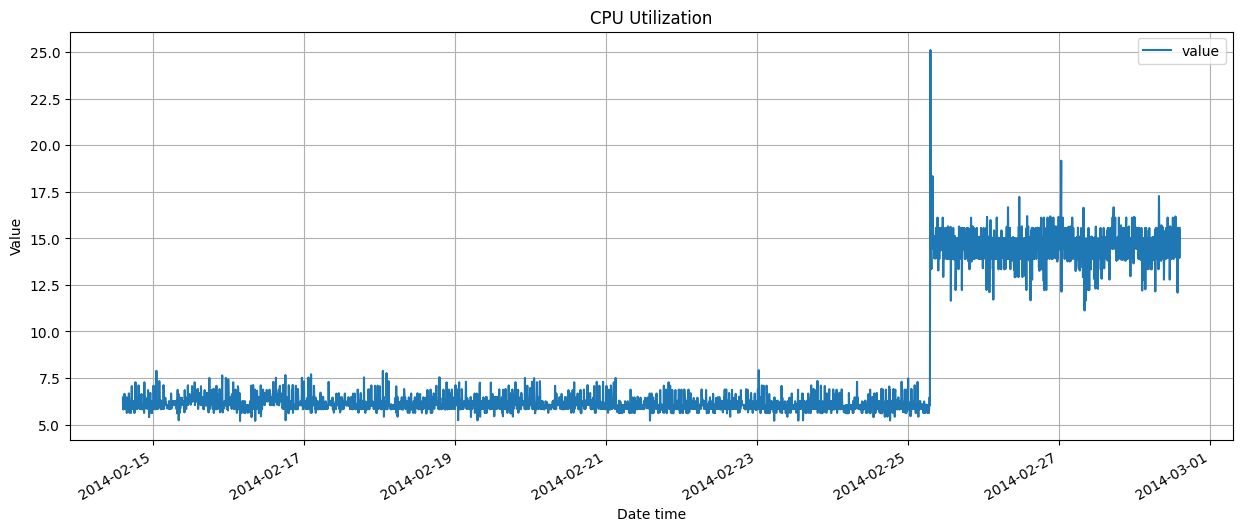

In [30]:
df.plot(x='timestamp', y='value', figsize=(15,6)) 
plt.title('CPU Utilization')
plt.xlabel('Date time')
plt.ylabel('Value')
plt.grid()
plt.show()

### (3) 필요 함수들 생성

1) reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [31]:
def recon_err(x, x_pred, threshold=0):
    err = np.mean(np.abs(x - x_pred), axis=1)
    result = pd.DataFrame({'DateTime':df['timestamp'] ,'value':df['value'], 'error':err})
    result['abnormal'] = np.where(result['error']> threshold, 1,0)
    result['DateTime'] = pd.to_datetime(result['DateTime'])

    groups = result.groupby('abnormal')
    fig, ax = plt.subplots(figsize=(15, 8))
    for name, group in groups:
        ax.plot(group.index, group.error, marker='x', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    # ax.text(threshold, max(group.index)-200 ,threshold  , color = 'r')
    ax.legend()
    plt.title("Reconstruction Error Plot")
    plt.ylabel("error")
    plt.xlabel("Data point index")
    plt.grid()
    plt.show()

    return result

## 2.데이터 준비

### (1) 스케일링

> * 전체를 스케일링하고
* 한꺼번에 3차원 변환
    * Sliding Window가 아닌, 구간으로 그대로 잘라서 3차원 만들 예정.
    * 여기서는 전체 데이터 4032건을 288개씩(하루씩) 겹치지 않게, 14개로 나눕니다. 

In [32]:
# 스케일링
scaler = MinMaxScaler()
df['scaled_value'] = scaler.fit_transform(df[['value']])
df.head()

,timestamp,value,scaled_value
0,2014-02-14 14:30:00,6.456,0.063576
1,2014-02-14 14:35:00,5.816,0.031436
2,2014-02-14 14:40:00,6.268,0.054135
3,2014-02-14 14:45:00,5.816,0.031436
4,2014-02-14 14:50:00,5.862,0.033746


### (2) 3차원 데이터셋으로 변환

In [33]:
# 3차원 변환
time_steps = 288

# 전체 데이터
sequence = np.array(df['scaled_value'])

# 전체 데이터 크기
samples = len(sequence)

# 나눌때 나머지가 있는지 확인
trim = samples % time_steps

# 만들어질 데이터 건수
subsequences = int(samples/time_steps)

# 나머지가 있다면 빼고, time_steps 씩 나누기.
tr_seq = sequence[:samples - trim]
tr_seq = tr_seq.reshape(subsequences, time_steps, 1)

In [34]:
tr_seq.shape

(14, 288, 1)

## 3.모델링

### (1) 모델 설계

In [35]:
model = Sequential([LSTM(32, input_shape=(time_steps, 1), return_sequences=True),
                    TimeDistributed(Dense(1)) ])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 288, 32)           4352      
                                                                 
 time_distributed (TimeDistr  (None, 288, 1)           33        
 ibuted)                                                         
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


### (2) 컴파일 및 학습

In [36]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(x=tr_seq, y=tr_seq, epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.0878
Epoch 2/50
1/1 [==============================] - 0s 100ms/step - loss: 0.0796
Epoch 3/50
1/1 [==============================] - 0s 113ms/step - loss: 0.0720
Epoch 4/50
1/1 [==============================] - 0s 108ms/step - loss: 0.0650
Epoch 5/50
1/1 [==============================] - 0s 109ms/step - loss: 0.0586
Epoch 6/50
1/1 [==============================] - 0s 104ms/step - loss: 0.0526
Epoch 7/50
1/1 [==============================] - 0s 108ms/step - loss: 0.0472
Epoch 8/50
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9/50
1/1 [==============================] - 0s 106ms/step - loss: 0.0376
Epoch 10/50
1/1 [==============================] - 0s 108ms/step - loss: 0.0334
Epoch 11/50
1/1 [==============================] - 0s 110ms/step - loss: 0.0296
Epoch 12/50
1/1 [==============================] - 0s 116ms/step - loss: 0.0263
Epoch 13/50
1/1 [==============================] - 0

### (3) 검증

* 예측

In [37]:
test_seq = tr_seq
pred = model.predict(test_seq)

1/1 [==============================] - 1s 696ms/step


* 평가

In [38]:
# 원래 2차원 구조로 변환.
test_seq = test_seq.reshape((test_seq.shape[0]*test_seq.shape[1]), test_seq.shape[2])
pred = pred.reshape((pred.shape[0]*pred.shape[1]), pred.shape[2])

errorsDF = test_seq - pred
print(errorsDF.shape)
rmse = mean_squared_error(test_seq, pred, squared = False)
print('Test RMSE: %.3f' % rmse)

(4032, 1)
Test RMSE: 0.044


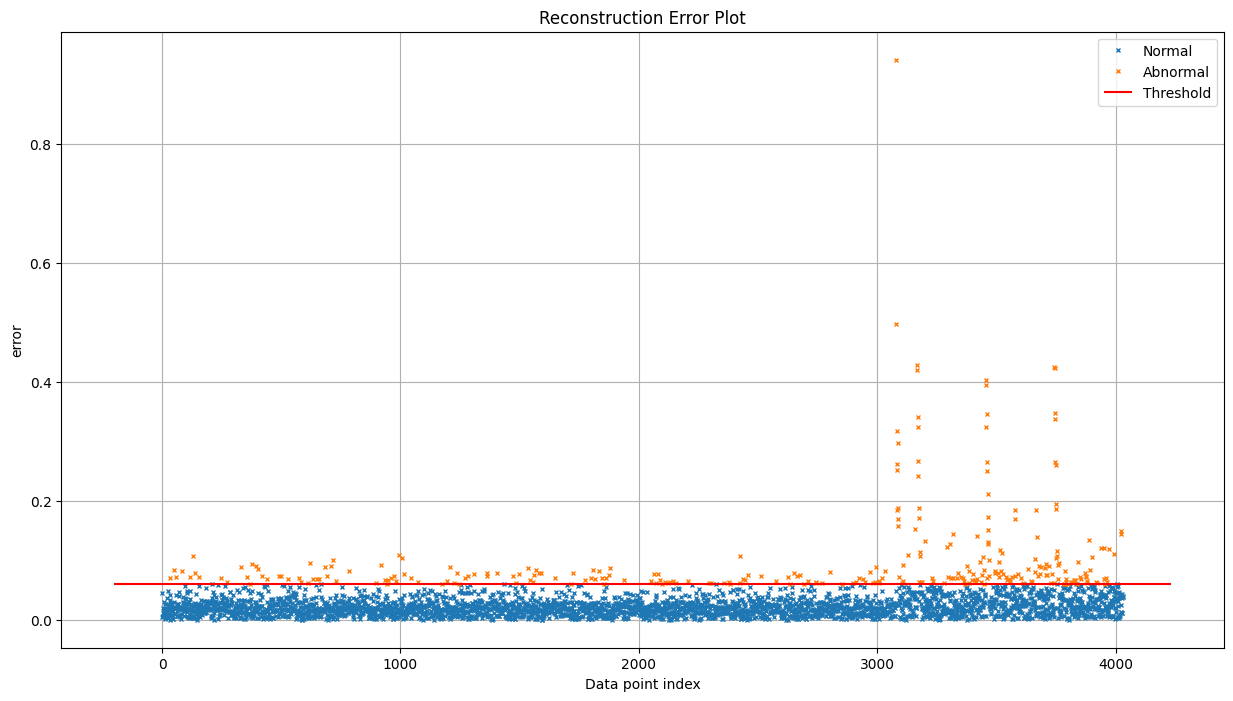

In [39]:
# err 크기에 따른 Abnormal 데이터 확인
# threshold 값 .06은 조정 가능.

result = recon_err(test_seq, pred, threshold = .06)

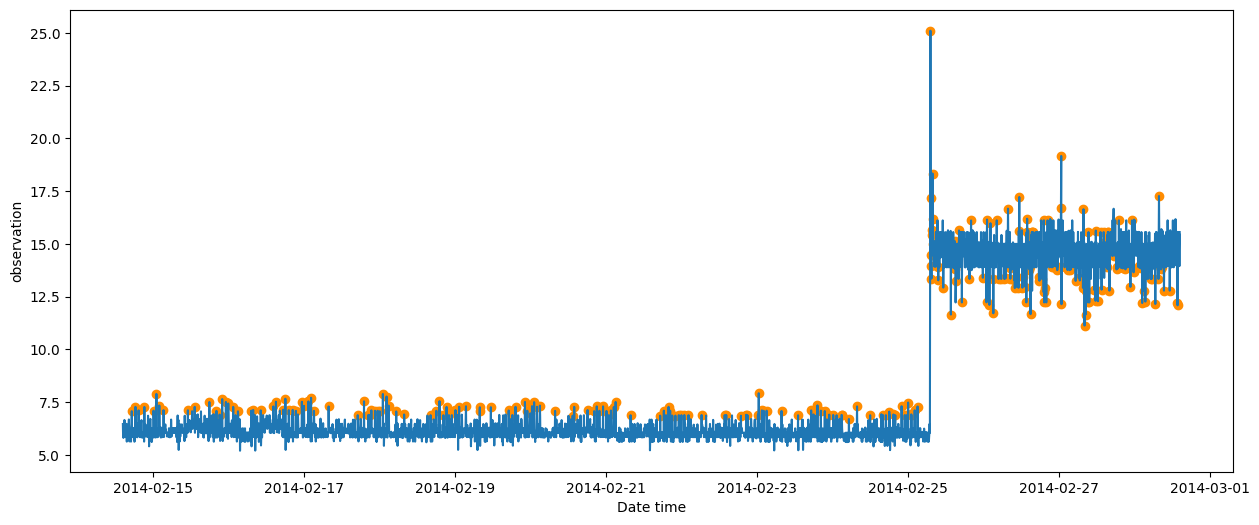

In [40]:
# 원래 데이터
plt.figure(figsize=(15, 6))
plt.plot(result['DateTime'], result['value'])

# Abnormal Data
temp = result.loc[result['abnormal'] == 1]
plt.scatter(temp['DateTime'].values, temp['value'], color='darkorange')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.show()

* 이 예제는 이미 지난 과거의 데이터에 대해서 Normal / Abnormal 을 판별하는 방식입니다. 앞으로 Abnormal이 발생할지를 예측하는 모델은 아닙니다.
